# Notebook to show results

Import libraries needed

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [2]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '
SHOW_COUNTS = False # Show how much many relevant datapoints have been read?  If False, the quality, or error will be shown instead.
CMAP = 'Set3'
CMAP_HEATMAP = 'cividis'

## Define standard function modules

In [3]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [4]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    return df

Filter out records for analysis

In [5]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    df = df[(df['shots'] == 1024)]
    return df

In [6]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [7]:
def find_quality(df, factor=1, round=None):
    df['quality'] =  factor* df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 * factor - df['quality']
    if round:
        df['quality'] = df['quality'].round(round)
        df['error'] = df['error'].round(round)
    return df

In [8]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]
    return df

In [9]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers', 'elapsed']]
    return df

## Analysis of slicing

In [10]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2


In [11]:
if SHOW_COUNTS:
    slice_count = df.groupby(['locations', 'slice']).count()
    slice_count.head()
    slice_count_pivot = slice_count.pivot_table(index='locations', columns='slice', values='quality')
    print(slice_count_pivot)

In [12]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,2.467162e-17,2.467162e-17
1,9,0.2,4.934325e-17,3.263749e-17
2,9,0.3,2.320455e-04,2.320455e-04
3,9,0.4,3.284963e-03,3.032663e-03
4,9,0.5,8.944480e-03,8.944480e-03


In [13]:
def plot_3d_graph_models(grouped_means, input, input2 = 'layers'):
    """plot a 3D bar graph of the given input data grouped by layers and locations""" 
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    input2_vals = sorted(grouped_means[input2].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    input2_map = {sli: i for i, sli in enumerate(input2_vals)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    # Assign colors for each location
    colors = plt.get_cmap(CMAP, len(input2_vals))  # or 'Set3', 'Paired', etc.
    input2_colors = {item: colors(i) for i, item in enumerate(input2_vals)}

    # Bar sizes
    dx = 0.5
    dy = 0.15

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = input2_map[row[input2]] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = input2_colors[row[input2]]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel(input2)
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(input2_map.values()))
    ax.set_yticklabels(list(input2_map.keys()))

    legend_handles = [mpatches.Patch(color=input2_colors[layer], label=layer) for layer in input2_vals]
    plt.legend(handles=legend_handles, title=input2, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by {input2} and locations'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [14]:
def plot_3d_graph_slice(grouped_means, input, show_sem=False):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    colors = plt.get_cmap(CMAP, len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar and cap width sizes
    dx = 0.5
    dy = 0.25
    cap_width = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']]   
        y = loc_map[row['locations']]
        x_bar = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y_bar = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z_bar = 0
        dz = row[input]
        if show_sem:
            error = row['sem']

        color = location_colors[row['locations']]
        ax.bar3d(x_bar , y_bar, z_bar, dx, dy, dz, color=color, shade=True)
        
        x_center = x + dx / 4
        y_center = y + dy / 4
        y_center = y

        if show_sem:
            if error > 0:
                #error bars
                ax.plot(
                    [x_center , x_center],
                    [y_center, y_center],
                    [0, dz + error],
                    color='black',
                    linewidth=2
                    )     
                # Horizontal cap at the top
                ax.plot(
                    [x_center - cap_width, x_center + cap_width],
                    [y_center, y_center],
                    [dz + error, dz + error],
                    color='black',
                    linewidth=2
                    )
    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by location and slice'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [15]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,2.467162e-17,2.467162e-17
1,9,0.2,4.934325e-17,3.263749e-17
2,9,0.3,2.320455e-04,2.320455e-04
3,9,0.4,3.284963e-03,3.032663e-03
4,9,0.5,8.944480e-03,8.944480e-03


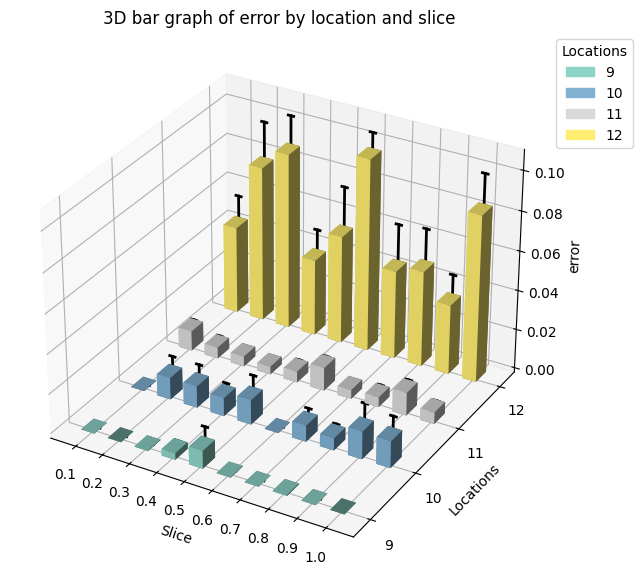

In [16]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

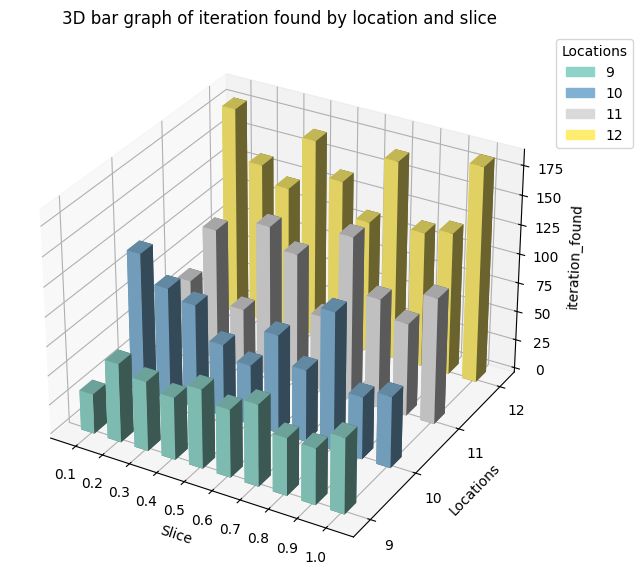

In [17]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of different qml models


In [18]:
qml_mode = read_data()
qml_mode = filter_results_qml(qml_mode)
qml_mode = find_quality(qml_mode, factor=100, round=1)
qml_mode = qml_mode[(qml_mode['slice'] == 0.8)]
qml_mode = qml_mode[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]

if SHOW_COUNTS:
    qml_mode_pivot = qml_mode.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc='count'
        )
else:
        qml_mode_pivot = qml_mode.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc='mean'
        )
qml_mode_pivot = qml_mode_pivot.round(1)
print(qml_mode_pivot)

mode           1      2
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9           98.5  100.0
10          97.3   99.4
11          98.8   99.5
12          96.1   95.2


In [19]:
qml_mode_summary = qml_mode_pivot.mean(axis=0).reset_index()
qml_mode_summary.head()

,mode,0
0,1,98.966667
1,2,99.344444


## Analysis of ml models with different numbers of layers

In [20]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [21]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()

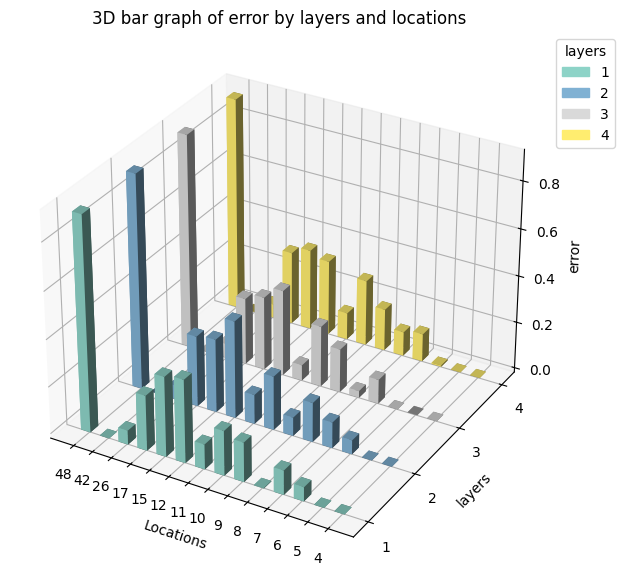

In [22]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [23]:
df['quality'] = df['quality']*100
if SHOW_COUNTS:
    ml_layer_pivot = df.pivot_table(
        index='locations', 
        columns='layers', 
        values='quality',
        aggfunc='count'
        )
else:
        ml_layer_pivot = df.pivot_table(
        index='locations', 
        columns='layers', 
        values='quality',
        aggfunc='mean'
        )
ml_layer_pivot = ml_layer_pivot.round(1)
print(ml_layer_pivot)


layers         1      2      3      4
locations                            
4          100.0  100.0  100.0  100.0
5          100.0  100.0  100.0  100.0
6           94.0   94.0  100.0   99.5
7           89.7   89.0   89.7   88.2
8           99.8   83.3   97.1   89.7
9           83.3   92.1   81.5   82.1
10          81.1   77.1   74.1   72.0
11          89.4   87.5   93.4   88.5
12          64.8   58.8   63.5   68.1
15          66.1   69.0   68.8   65.6
17          76.6   70.0   71.7   68.9
26          94.1   94.1   94.1   94.1
42         100.0  100.0  100.0  100.0
48           9.3    9.2    8.9    9.4


In [24]:
ml_layer_summary = ml_layer_pivot.mean(axis=0).reset_index()
ml_layer_summary = ml_layer_summary.round(1)
ml_layer_summary.head()

,layers,0
0,1,82.0
1,2,80.3
2,3,81.6
3,4,80.4


# Impact of hot start

### QML - hot start

In [25]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [26]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [27]:
if SHOW_COUNTS:
    hot_qml_pivot = hot_qml_mean.pivot_table(
        index='locations', 
        columns='hot_start', 
        values='quality',
        aggfunc='count',
        )
else:
    hot_qml_pivot = hot_qml_mean.pivot_table(
        index='locations', 
        columns='hot_start', 
        values='quality',
        aggfunc='mean',
        )
hot_qml_pivot = hot_qml_pivot.round(1)
print(hot_qml_pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9          100.0  100.0
10          99.4   98.9
11          99.5  100.0
12          95.2   93.3


In [28]:
hot_qml_summary = hot_qml_pivot.mean(axis=0).reset_index()
hot_qml_summary.head()

,hot_start,0
0,False,99.344444
1,True,99.133333


### Classical ML - hot start

In [29]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [30]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [31]:
if SHOW_COUNTS:
    hot_ml_pivot = hot_ml_mean.pivot_table(
        index='locations', 
        columns='hot_start', 
        values='quality',
        aggfunc='count'
        )
else:
    hot_ml_pivot = hot_ml_mean.pivot_table(
        index='locations', 
        columns='hot_start', 
        values='quality',
        aggfunc='mean'
        )
hot_ml_pivot = hot_ml_pivot.round(1)
print(hot_ml_pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6           98.3   88.7
7           88.6  100.0
8           90.9   94.6
9           83.3  100.0
10          75.8   90.5
11          89.1   93.0
12          66.2   78.8
15          66.4   70.4
17          70.2   70.7
26          94.1   78.0
42         100.0   77.7
48           9.3    9.4


In [32]:
hot_ml_summary = hot_ml_pivot.mean(axis=0).reset_index()
hot_ml_summary.head()

,hot_start,0
0,False,80.871429
1,True,82.271429


## Impact of Gray encoding

### QML - Gray

In [33]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', columns='gray', values='quality')
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


gray       False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9          100.0   99.4
10          99.4   98.5
11          99.5   98.8
12          95.2   96.7


In [34]:

gray_summary_qml = gray_qml_pivot.mean(axis=0).reset_index()
gray_summary_qml.head(20)

,gray,0
0,False,99.344444
1,True,99.266667


### Classical ML - Gray

In [ ]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

KeyError: 'model'

In [ ]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(1)
print(gray_ml_pivot)

In [ ]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

## Impact of formalation

### QML - formulation

In [ ]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
form_qml_pivot = form_qml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_qml_pivot)


In [ ]:
form_summary_qml = form_qml_pivot.mean(axis=0).reset_index()
form_summary_qml.head()

## Classical ML formulation

In [ ]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 26)]  #issue calculating large locations

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
form_ml_pivot = form_ml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_ml_pivot)

In [ ]:
form_summary_ml = form_ml_pivot.mean(axis=0).reset_index()
form_summary_ml.head()

## Impact of changing minibatch size for ML

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['runid'] == '20250427-22-43-45')]
df = find_quality(df)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed']]

if SHOW_COUNTS:
    shots_mean_ml = df.groupby(['locations', 'shots',]).count().reset_index()
else:
    shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()

shots_mean_ml['quality'] = shots_mean_ml['quality']*100

shots_ml_pivot = shots_mean_ml.pivot_table(index='locations', columns='shots', values='quality')
shots_ml_pivot = shots_ml_pivot.round(1)
print(shots_ml_pivot)

In [ ]:
input = 'error'
plot_3d_graph_models(shots_mean_ml, input, input2='shots'), 

In [ ]:
shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality']*100
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

## Impact of circuits (models) on QML

In [ ]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df, factor=100)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 0.8)]
df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 
         'quality', 'error','mode', ]]

In [ ]:
#mode_mean_qml = df.groupby(['locations', 'mode',]).mean().reset_index()
if SHOW_COUNTS:
    circuit_qml_pivot = df.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc='count'  # or 'first', 'max', etc.
        )
else:
    circuit_qml_pivot = df.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc='mean'  # or 'first', 'max', etc.
        )
circuit_qml_pivot = circuit_qml_pivot.round(1)
print(circuit_qml_pivot)

In [ ]:
#summary_mean_qml = df.groupby([ 'mode',]).mean().reset_index()
circuit_qml_summary_pivot = circuit_qml_pivot.mean(axis=0).reset_index()
circuit_qml_summary_pivot.head()


## Impact of optimiser on Classical ML

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['gradient_type'] == 'SGD')]

df = find_quality(df, factor=100)

df_SGD = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

In [ ]:
df_SGD.head()

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 0.001)]
df = df[(df['weight_decay'] == 0.0032)]
df = df[(df['gradient_type'] == 'Adam')]

df = find_quality(df, factor=100)

df_Adam = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

df_Adam.head()

In [ ]:
df_combined = pd.concat([df_SGD, df_Adam], ignore_index=True)
df_combined['quality'] = df_combined['quality'].round(1)

In [ ]:
if SHOW_COUNTS:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).count().reset_index()
else:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).mean().reset_index()

In [ ]:
optimiser_mean_ml = optimiser_mean_ml.round(1)
optimiser_mean_ml.head()

In [ ]:
optimiser_ml_pivot = optimiser_mean_ml.pivot_table(
    index='locations', 
    columns=['gradient_type', 'shots'], 
    values='quality',
    aggfunc='mean'  # or 'first', 'max', etc.
    )
optimiser_ml_pivot = optimiser_ml_pivot.round(1)
print(optimiser_ml_pivot)

In [ ]:
optimiser_ml_summary_pivot = optimiser_mean_ml.pivot_table(
    index='gradient_type', 
    columns=['shots'], 
    values='quality',
    aggfunc='mean'  # or 'first', 'max', etc.
    )
optimiser_ml_summary_pivot = optimiser_ml_summary_pivot.round(1)
print(optimiser_ml_summary_pivot)

In [ ]:

optimiser_summary_ml = optimiser_mean_ml.pivot_table(index='gradient_type', values='quality')
optimiser_summary_ml.head()

### Adam hyperparameter training

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] == 12)]
df =df[df['gradient_type'] == 'Adam']
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', ]]

In [ ]:
if SHOW_COUNTS:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
adam_mean_ml.head()

In [ ]:
def plot_heatmap(input: pd.DataFrame,
                 title: str,
                 x_label:str,
                 y_label:str,
                 )-> None:
    """Plot a heat map of the given input data."""
    # Prepare the data
    heatmap_data = input.values
    x_labels = input.columns.format()
    y_labels = input.index

    # Create the plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(heatmap_data, aspect='auto', cmap=CMAP_HEATMAP)

    # Add colorbar
    plt.colorbar(im, label='Solution Quality')

    # Set axis ticks and labels
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    # Annotate each cell with the numeric value
    for i in range(heatmap_data.shape[0]):       # rows
        for j in range(heatmap_data.shape[1]):   # columns
            value = heatmap_data[i, j]
            if not np.isnan(value):  # skip missing values
                if value > 80:
                    color = 'black'
                else:
                    color = 'white'
                plt.text(j, i, f"{value:.1f}", ha='center', va='center', color=color)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.tight_layout()
plt.show()

In [ ]:
adam_summary_ml = adam_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(adam_summary_ml, 
             'Adam Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )


## SGD hyper parameter training

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 2)]
df = df[(df['locations'] == 10)]
df =df[df['gradient_type'] == 'SGD']
df =df[df['mode'] == 8]
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', 'layers']]

In [ ]:
df = df[(df['momentum'] == 0.8)]
if SHOW_COUNTS:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
SGD_mean_ml.head()

In [ ]:
SGD_summary_ml = SGD_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(SGD_summary_ml, 
             'SGD Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )

## ML initialisation with different values

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['gradient_type'] == 'SGD')]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 256


)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    mode_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    mode_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

mode_mean_ml.head()

In [ ]:
if SHOW_COUNTS:
    mode_ml_pivot = df.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc='count'
        )
else:
    mode_ml_pivot = df.pivot_table(
        index='locations', 
        columns=['mode'], 
        values='quality',
        aggfunc='mean'  # or 'first', 'max', etc.
        )
mode_ml_pivot = mode_ml_pivot.round(1)
print(mode_ml_pivot)

In [ ]:
mode_summary_ml = df.pivot_table(index='mode', values='quality')
mode_summary_ml.head()